# 1. Import Library

# 数据准备

In [9]:
# 导入所需的模块
import urllib.request
import os
import tarfile
################下载IMDB数据集###########################
#下载地址
url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
#设置存储文件的路径
filepath="aclImdb_v1.tar.gz"
#判断文件不存在就会下载文件
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
#判断解压缩目录是否存在，打开压缩文件，解压缩到相应目录
if not os.path.exists("./aclImdb"):
    tfile = tarfile.open("./aclImdb_v1.tar.gz", 'r:gz')
    result = tfile.extractall('imdb/')

downloaded: ('aclImdb_v1.tar.gz', <http.client.HTTPMessage object at 0x000001DDD11EB390>)


In [10]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [11]:
import re
def rm_tags(text):
    re_tag = re.compile(r'<[^>]+>')
    return re_tag.sub('', text)

In [12]:
import os
def read_files(filetype):
    path = "imdb/aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

In [15]:
y_train,train_text=read_files("train")

read train files: 25000


In [16]:
y_test,test_text=read_files("test")

read test files: 25000


In [17]:
token = Tokenizer(num_words=2000)
token.fit_on_texts(train_text)

In [18]:
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq  = token.texts_to_sequences(test_text)

In [19]:
x_train = sequence.pad_sequences(x_train_seq, maxlen=100)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=100)

# 建立模型

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
model = Sequential()
model.add(Embedding(output_dim=32,
                    input_dim=2000, 
                    input_length=100))
model.add(Dropout(0.2))

In [24]:
model.add(Flatten())
model.add(Dense(units=256,activation='relu' ))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid' ))

In [25]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 883,713
Trainable params: 883,713
Non-trainable params: 0
_________________________________________________________________
None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 883,713
Trainable params: 883,713
Non-trainable params: 0
_________________________________________________________________


# 训练模型

In [26]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
train_history =model.fit(x_train, y_train,batch_size=100, 
                         epochs=10,verbose=2,
                         validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 8s - loss: 0.4698 - acc: 0.7613 - val_loss: 0.5297 - val_acc: 0.7510
Epoch 2/10
 - 8s - loss: 0.2650 - acc: 0.8924 - val_loss: 0.4859 - val_acc: 0.7904
Epoch 3/10
 - 8s - loss: 0.1568 - acc: 0.9433 - val_loss: 0.5976 - val_acc: 0.7726
Epoch 4/10
 - 8s - loss: 0.0766 - acc: 0.9740 - val_loss: 0.9730 - val_acc: 0.7210
Epoch 5/10
 - 8s - loss: 0.0522 - acc: 0.9812 - val_loss: 1.0432 - val_acc: 0.7440
Epoch 6/10
 - 8s - loss: 0.0390 - acc: 0.9861 - val_loss: 0.9267 - val_acc: 0.7816
Epoch 7/10
 - 8s - loss: 0.0308 - acc: 0.9889 - val_loss: 1.1730 - val_acc: 0.7554
Epoch 8/10
 - 8s - loss: 0.0286 - acc: 0.9898 - val_loss: 1.2194 - val_acc: 0.7544
Epoch 9/10
 - 8s - loss: 0.0253 - acc: 0.9909 - val_loss: 1.1011 - val_acc: 0.7788
Epoch 10/10
 - 8s - loss: 0.0236 - acc: 0.9910 - val_loss: 1.4060 - val_acc: 0.7388


In [27]:
scores=model.evaluate(x_test,y_test,verbose=1)
print(scores[1])

25000/25000 [==============================] - 2s 94us/step
0.81244


In [29]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

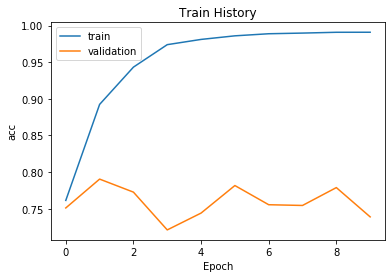

In [30]:
show_train_history(train_history,'acc','val_acc')

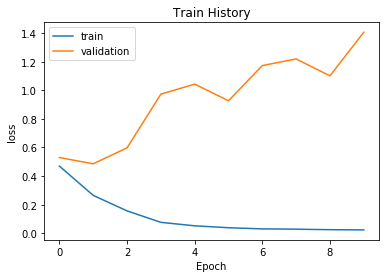

In [31]:
show_train_history(train_history,'loss','val_loss')

# 评估模型的准确率

In [21]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]

24320/25000 [============================>.] - ETA: 0s

0.80288000000000004

# 预测概率

In [22]:
probility=model.predict(x_test)

In [23]:
probility[:10]

array([[ 0.99994957],
       [ 0.99999988],
       [ 0.76855087],
       [ 0.99998605],
       [ 0.9999541 ],
       [ 0.99995875],
       [ 0.99999988],
       [ 0.99994111],
       [ 0.99983203],
       [ 0.99997246]], dtype=float32)

In [24]:
for p in probility[12500:12510]:
    print(p)

[ 0.24089573]
[  9.92533023e-06]
[  1.74154319e-11]
[ 0.00034091]
[ 0.9982065]
[ 0.00352889]
[ 0.99975556]
[  3.24299745e-12]
[  8.06112166e-06]
[ 0.72043139]


# 预测结果

In [25]:
predict=model.predict_classes(x_test)

24064/25000 [===========================>..] - ETA: 0s

In [26]:
predict[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [27]:
predict_classes=predict.reshape(-1)
predict_classes[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# 查看预测结果

In [28]:
SentimentDict={1:'正面的',0:'负面的'}
def display_test_Sentiment(i):
    print(test_text[i])
    print('标签label:',SentimentDict[y_test[i]],
          '预测结果:',SentimentDict[predict_classes[i]])

In [29]:
display_test_Sentiment(2)

As a recreational golfer with some knowledge of the sport's history, I was pleased with Disney's sensitivity to the issues of class in golf in the early twentieth century. The movie depicted well the psychological battles that Harry Vardon fought within himself, from his childhood trauma of being evicted to his own inability to break that glass ceiling that prevents him from being accepted as an equal in English golf society. Likewise, the young Ouimet goes through his own class struggles, being a mere caddie in the eyes of the upper crust Americans who scoff at his attempts to rise above his standing. What I loved best, however, is how this theme of class is manifested in the characters of Ouimet's parents. His father is a working-class drone who sees the value of hard work but is intimidated by the upper class; his mother, however, recognizes her son's talent and desire and encourages him to pursue his dream of competing against those who think he is inferior.Finally, the golf scenes

In [30]:
predict_classes[12500:12510]

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [31]:
display_test_Sentiment(12502)

First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like cliché'e version of gangsters.The movie doesn't take more than five minutes to explain what is going on before we're already at the warehouse There is not a single sympathetic character in this movie, except for the homeless guy, who is also the only one with half a brain.Bill Paxton and William Sadler are both hill billies and Sadlers character is just as much a villain as the gangsters. I did'nt like him right from the start.The movie is filled with pointless violence and Walter Hills specialty: people falling through windows with glass flying everywhere. There is pretty much no plot and it is a big problem when you root for no-one. Everybody dies, except from Paxton and the homeless guy and everybody get what they deserve.The only two black people that can act is the homeless guy and the junkie but they're actors by 

In [32]:
#预测新的影评

In [33]:
input_text='''
Oh dear, oh dear, oh dear: where should I start folks. I had low expectations already because I hated each and every single trailer so far, but boy did Disney make a blunder here. I'm sure the film will still make a billion dollars - hey: if Transformers 11 can do it, why not Belle? - but this film kills every subtle beautiful little thing that had made the original special, and it does so already in the very early stages. It's like the dinosaur stampede scene in Jackson's King Kong: only with even worse CGI (and, well, kitchen devices instead of dinos).
The worst sin, though, is that everything (and I mean really EVERYTHING) looks fake. What's the point of making a live-action version of a beloved cartoon if you make every prop look like a prop? I know it's a fairy tale for kids, but even Belle's village looks like it had only recently been put there by a subpar production designer trying to copy the images from the cartoon. There is not a hint of authenticity here. Unlike in Jungle Book, where we got great looking CGI, this really is the by-the-numbers version and corporate filmmaking at its worst. Of course it's not really a "bad" film; those 200 million blockbusters rarely are (this isn't 'The Room' after all), but it's so infuriatingly generic and dull - and it didn't have to be. In the hands of a great director the potential for this film would have been huge.
Oh and one more thing: bad CGI wolves (who actually look even worse than the ones in Twilight) is one thing, and the kids probably won't care. But making one of the two lead characters - Beast - look equally bad is simply unforgivably stupid. No wonder Emma Watson seems to phone it in: she apparently had to act against an guy with a green-screen in the place where his face should have been. 
'''

In [34]:
input_seq = token.texts_to_sequences([input_text])

In [35]:
len(input_seq[0])

285

In [36]:
pad_input_seq  = sequence.pad_sequences(input_seq , maxlen=100)

In [37]:
len(pad_input_seq[0])

100

In [38]:
predict_result=model.predict_classes(pad_input_seq)

1/1 [==============================] - 0s


In [39]:
predict_result[0][0]

0

In [40]:
SentimentDict[predict_result[0][0]]

'负面的'

In [34]:
SentimentDict={1:'正面的',0:'负面的'}
def predict_review(input_text):
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq  = sequence.pad_sequences(input_seq , maxlen=100)
    predict_result=model.predict_classes(pad_input_seq)
    print(SentimentDict[predict_result[0][0]])

In [42]:
#http://www.imdb.com/title/tt2771200/
#http://www.imdb.com/title/tt2771200

In [35]:
predict_review('''
It's hard to believe that the same talented director who made the influential cult action classic The Road Warrior had anything to do with this disaster.
Road Warrior was raw, gritty, violent and uncompromising, and this movie is the exact opposite. It's like Road Warrior for kids who need constant action in their movies.
This is the movie. The good guys get into a fight with the bad guys, outrun them, they break down in their vehicle and fix it. Rinse and repeat. The second half of the movie is the first half again just done faster.
The Road Warrior may have been a simple premise but it made you feel something, even with it's opening narration before any action was even shown. And the supporting characters were given just enough time for each of them to be likable or relatable.
In this movie there is absolutely nothing and no one to care about. We're supposed to care about the characters because... well we should. George Miller just wants us to, and in one of the most cringe worthy moments Charlize Theron's character breaks down while dramatic music plays to try desperately to make us care.
Tom Hardy is pathetic as Max. One of the dullest leading men I've seen in a long time. There's not one single moment throughout the entire movie where he comes anywhere near reaching the same level of charisma Mel Gibson did in the role. Gibson made more of an impression just eating a tin of dog food. I'm still confused as to what accent Hardy was even trying to do.
I was amazed that Max has now become a cartoon character as well. Gibson's Max was a semi-realistic tough guy who hurt, bled, and nearly died several times. Now he survives car crashes and tornadoes with ease?
In the previous movies, fuel and guns and bullets were rare. Not anymore. It doesn't even seem Post-Apocalyptic. There's no sense of desperation anymore and everything is too glossy looking. And the main villain's super model looking wives with their perfect skin are about as convincing as apocalyptic survivors as Hardy's Australian accent is. They're so boring and one-dimensional, George Miller could have combined them all into one character and you wouldn't miss anyone.
Some of the green screen is very obvious and fake looking, and the CGI sandstorm is laughably bad. It wouldn't look out of place in a Pixar movie.
There's no tension, no real struggle, or any real dirt and grit that Road Warrior had. Everything George Miller got right with that masterpiece he gets completely wrong here. 
''')

负面的


In [44]:
predict_review('''
Sure, I'm a huge film snob who (on the surface) only likes artsy-fartsy foreign films from before the 60's, but that hasn't stopped me from loving Disney's Beauty & The Beast; in fact, it's probably my favorite American animated film and is easily Disney's finest work. It's beautiful, it's breathtaking, it's warm, it's hilarious, it's captivating, and, in Disney fashion, it's magical. When I learned that Disney would be remaking their classic films, B&TB was undeniably the best wrapped package. How could they go wrong?
Oh man, they went wrong.
First thing's first: this film is so flat. The directing was dull and uninteresting throughout the entire film and it honestly felt like one of the Twilight sequels...and then I looked it up and found out that, yes, director Bill Condon was the man behind Breaking Dawn parts 1 & 2. Every shot looks bored and uninterested, which contrasts heavily with the original animated film that was constantly popping with vibrancy. The script too is boring because it's almost a complete remake of the original, though I guess most people won't mind that.
Next: the CGI is horrid. Although I didn't care for The Jungle Book from last year, I could at least admit that the CGI was breathtaking. The same cant be said for this film. Characters like Lumière, Cogsworth, Mrs Potts, and most of the cursed appliances have very strange, lifeless faces that are pretty off putting to be looking at for such a long time. All of the sets too look artificial and fake, especially the town towards the beginning. However, the biggest offender is easily and infuriatingly the character that mattered most: The Beast. The CGI on the Beast's face is so distracting that it completely takes you out of the film. His eyes are completely devoid of soul, and his mouth is a gaping video game black hole of fiction. Klaus Kinski looked much better in the Faerie Tale Theatre episode of Beauty & The Beast, and that was a 1984 TV show episode. But do you know why it looked better? Because it was an actual face with actual eyes, not some video game computerized synthetic monstrosity. When will studios learn that practical effects will always top CGI?
Finally: wasted casting. Emma Watson is beautiful, but she's no Belle. She is completely devoid of the warmth and humanity that made the animated Belle so beloved. Instead, she is cold and heartless throughout most of the film. Kevin Kline is 100% wasted and does nothing except look old. Ian McKellan, Ewan McGregor, Emma Thompson, and even Dan Stevens as the Beast are very expendable and could've been played by anyone else. The only good characters are Gaston and LeFou, mostly because they are fun and played by actors who breathe new life into their original shapes. If anything, this film should've been about Gaston and LeFou, but that would never happen because that would mean Disney couldn't cater to blind nostalgic 90's kids.
Overall, this film is a complete bore. It could've been better if even the special effects were good, but the CGI in particular is horrendous. I'm all for Disney remaking their nostalgia- catering 90's films, but they need to be interesting. This film, sadly, is not. Even the Christmas sequel is better than this film because it's at least something. 
''')

负面的


In [37]:
predict_review('''
I was really looking forward to this film. Not only has Disney recently made excellent live-action versions of their animated masterpieces (Jungle Book, Cinderella), but the cast alone (Emma Watson, Ian McKellen, Kevin Kline) already seemed to make this one a sure hit. Well, not so much as it turns out.
Some of the animation is fantastic, but because characters like Cogsworth (the clock), Lumière (the candelabra) and Chip (the little tea cup) now look "realistic", they lose a lot of their animated predecessors' charm and actually even look kind of creepy at times. And ironically - unlike in the animated original - in this new realistic version they only have very limited facial expressions (which is a creative decision I can't for the life of me understand).
Even when it works: there can be too much of a good thing. The film is overstuffed with lush production design and cgi (which is often weirdly artificial looking though) but sadly lacking in charm and genuine emotion. If this were a music album, I'd say it is "over-produced" and in need of more soul and swing. The great voice talent in some cases actually seems wasted, because it drowns in a sea of visual effects that numbs all senses. The most crucial thing that didn't work for me, though, is the Beast. He just never looks convincing. The eyes somehow don't look like real eyes and they're always slightly off.
On the positive side, I really liked Gaston, and the actor who played him, Luke Evans, actually gave the perhaps most energized performance of all. Kevin Kline as Belle's father has little to do but to look fatherly and old, but he makes the most of his part. Speaking of Belle, now that I've seen the film, I think her role was miscast. I think someone like Rachel McAdams would actually have been a more natural, lively and perhaps a bit more feisty Belle than Emma Watson.
If you love the original, you might want to give this one a pass, it's really not that good (although at least the songs were OK). Also, I'd think twice before bringing small children; without cute animated faces, all those "realistic" looking creatures and devices can be rather frightening for a child. ''')

正面的


In [51]:
predict_review('''
I do not write reviews based on technical aspects. I go see movies to take me from the norm of life. 
This movie did exactly that for me. It was excellent in every sense. 
The actors brought the characters to life better than I could have imagined. 
People, in my opinion, tend to forget what movies are meant to do. Just enjoy them. 
This movie was graceful, enchanting and for goodness sake, the gay part was not that big a deal.
''')

正面的


In [49]:
predict_review('''I reserve 1/10 ratings for films that offended me, and this one I was so disappointed about. 
Beauty and the Beast is such a beautiful and universally adored classic Disney film. 
I thought how can this be anything but great. But unfortunately they just chose the totally wrong Belle. 
It made me realise that so much that is wonderful about the original relies on Belle because she is so wonderful, wise, kind, and beautiful. Emma Watson is the perfect Hermione and I would consider myself a fan of hers, however right now she is at the point in her life where she is exploring her masculinity and subverting the attempts by the media and filmmakers to feminise her. 
Cutting her hair, talking about feminism, etc. This is fine, many women go through this stage. 
But her Belle just lacks all of the wonderful femininity that shines through the real Belle. It was a restrained and reserved portrayal and made the whole film so disappointing. I wouldn't have been surprised if in the end the beast became a house husband and Belle went to work as an office manager. The energies for me were just totally off.
''')

负面的


# serialize model to JSON

In [40]:
model_json = model.to_json()
with open("Imdb_mlp_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("Imdb_mlp_model.h5")
print("Saved model to disk")

Saved model to disk
